In [1]:
from PY_PAD_on_sphere_library import *
import netCDF4
from netCDF4 import Dataset

## Read and preprocess sample data

### Read sample netcdf fields. Both fields are defined in a regular 0.25 deg lat-lon grid (i.e. same grid)

In [2]:
nc_file_id = Dataset("PY_PAD_on_sphere_example_field_A.nc", "r")
lon1 = nc_file_id.variables["lon"][:].data
lat1 = nc_file_id.variables["lat"][:].data
field1 = nc_file_id.variables["precipitation"][:].data
nc_file_id.close()

nc_file_id = Dataset("PY_PAD_on_sphere_example_field_B.nc", "r")
field2 = nc_file_id.variables["precipitation"][:].data
nc_file_id.close()

### Convert fields to one-dimensional arrays of lats, lons, and precipitation amounts for all grid points

In [3]:
values1 = np.reshape(field1, (-1))
values2 = np.reshape(field2, (-1))
lons = np.tile(lon1, field1.shape[0])
lats = np.repeat(lat1, field1.shape[1])

### Compute grid-area and convert precipitation height in mm to precipitation volume in m^3:

In [4]:
dlat = 0.25  # resoltion of lat lon grid of the input fields
grid_point_area_size = (
    np.deg2rad(dlat)
    * Earth_radius
    * np.deg2rad(dlat)
    * Earth_radius
    * np.cos(np.deg2rad(lats))
)
values_prec_volume1 = values1 / 1000.0 * grid_point_area_size
values_prec_volume2 = values2 / 1000.0 * grid_point_area_size

## Compute PAD-on-sphere attributions

In [5]:
[PAD_attributions, non_attributed_values1, non_attributed_values2] = (
    calculate_attributions_from_numpy(
        values_prec_volume1,
        values_prec_volume2,
        lats,
        lons,
        same_grid=True,
        distance_cutoff=3000 * 1000,
    )
)

----- preprocessing: 0.0163556 s
----- kdtree construction: 0.408526 s
----- attribution: 6.68804 s


The PAD_attributions array contains the data on all attributions. \
The dimension of the array is (number_of_all_attributions,4) with:
 -  PAD_attributions[:,0] being the attributed distances
 -  PAD_attributions[:,1] being the attributed amounts
 -  PAD_attributions[:,2] being the indexes of the associated grid point in the first field
 -  PAD_attributions[:,3] being the indexes of the associated grid point in the second field

The non_attributed_values1 and non_attributed_values2 arrays contain the data about precipitation that was not attributed. \
Both arrays are one-dimensional with the dimension equal to the values_prec_volume1 and values_prec_volume2 arrays, respectively

## Compute summary statistics and plots

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Calculate the average PAD value and the portion of unattributed precipitation:

In [7]:
PAD_distance_value = calculate_PAD_on_sphere_from_attributions(PAD_attributions)
print("PAD distance value: " + str(np.round(PAD_distance_value / 1000, 1)) + " km")

PAD distance value: 579.6 km


In [8]:
print( "Portion of unattributed precipitation in field 1: "
    + str(np.round(100 * np.sum(non_attributed_values1) / np.sum(values_prec_volume1), 2)) + " %" )
print( "Portion of unattributed precipitation in field 2: "
    + str(np.round(100 * np.sum(non_attributed_values2) / np.sum(values_prec_volume2), 2)) + " %" )

Portion of unattributed precipitation in field 1: 2.9 %
Portion of unattributed precipitation in field 2: 5.11 %


### Draw the attribution PDF:

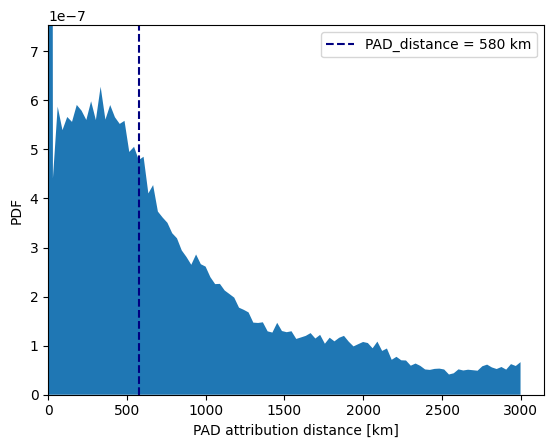

In [9]:
hist = np.histogram(
    PAD_attributions[:, 0],
    bins=100,
    range=(0, np.max(PAD_attributions[:, 0])),
    density=True,
    weights=PAD_attributions[:, 1],
)
PAD_PDF = np.asarray([hist[1][:-1], hist[0][:]]).transpose(1, 0)
fig, ax = plt.subplots()
plt.fill_between(PAD_PDF[:, 0] / 1000, PAD_PDF[:, 1], 0, linestyle="-")
plt.axvline(
    PAD_distance_value / 1000,
    color="navy",
    label="PAD_distance = " + str(int(np.round(PAD_distance_value / 1000, 0))) + " km",
    linestyle="--",
)
plt.ylim(bottom=0, top=1.2 * np.max(PAD_PDF[10:, 1]))
plt.xlim(left=0)
plt.xlabel("PAD attribution distance [km]")
plt.ylabel("PDF")
leg = plt.legend(loc="upper right")
plt.show()
plt.close()

### Visualize the attributions

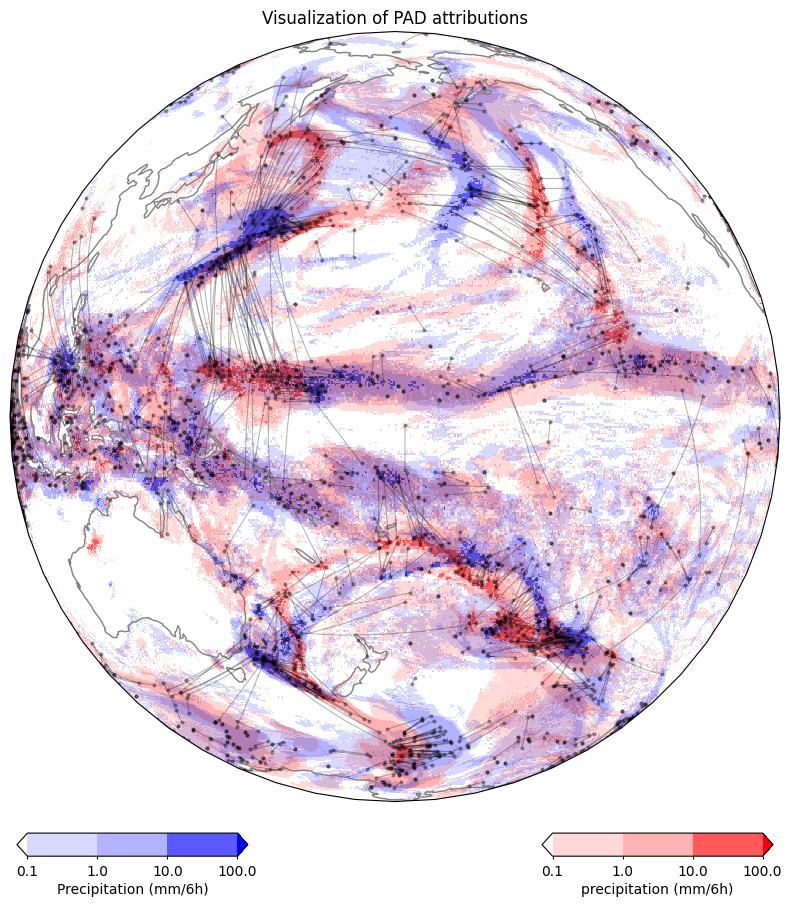

In [10]:
# Visualize PAD attributions in an Orthographic projection

# number of attribution lines shown in the figure
number_of_shown_attributions = 2000
# cumulative distribution
cumulative = np.cumsum(PAD_attributions[:, 1] / np.sum(PAD_attributions[:, 1]))
# randomly select attributions - the probability of selection is affected by the attribution value
rand = np.random.rand(number_of_shown_attributions)
ind = np.searchsorted(cumulative, rand)
PAD_attributions_selected = PAD_attributions[ind]

projX = cartopy.crs.Orthographic(central_longitude=180, central_latitude=0, globe=None)
projX._threshold = projX._threshold / 50.0  # set finer threshold

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=projX)
ax.set_global()

plt.title("Visualization of PAD attributions")

fontsize = 10

cmap_b = matplotlib.colors.LinearSegmentedColormap.from_list("rb_cmap", ["white", (0.7, 0.7, 1.0), "blue"], 512)
cmap_r = matplotlib.colors.LinearSegmentedColormap.from_list("rb_cmap", ["white", (1.0, 0.7, 0.7), "red"], 512)

levels = [0.1, 1, 10, 100]
norm_b = matplotlib.colors.BoundaryNorm(boundaries=levels, ncolors=cmap_b.N, extend="both")
norm_r = matplotlib.colors.BoundaryNorm(boundaries=levels, ncolors=cmap_r.N, extend="both")

# conver to rgb values using colormaps
f1x = cmap_b(norm_b(field1))
f2x = cmap_r(norm_r(field2))

# get the combined colors using the multiply effect
fx = f1x * f2x

img_extent = (0, 360, -90, 90)
img = plt.imshow(
    fx,
    transform=cartopy.crs.PlateCarree(),
    interpolation="nearest",
    origin="lower",
    extent=img_extent,
)

axins_b = inset_axes(
    ax,
    width="30%",
    height="3%",
    bbox_to_anchor=(0.0, -0.08, 1, 1),
    loc="lower left",
    bbox_transform=ax.transAxes,
)
cb_b = matplotlib.colorbar.ColorbarBase(
    axins_b,
    orientation="horizontal",
    cmap=cmap_b,
    norm=norm_b,
    extend="both",
    label="This is a label",
    ticks=levels,
)
cb_b.set_label("Precipitation (mm/6h)", fontsize=fontsize, labelpad=3)
cb_b.ax.tick_params(labelsize=fontsize, length=2)

axins_r = inset_axes(
    ax,
    width="30%",
    height="3%",
    bbox_to_anchor=(0.0, -0.08, 1, 1),
    loc="lower right",
    bbox_transform=ax.transAxes,
)
cb_r = matplotlib.colorbar.ColorbarBase(
    axins_r,
    orientation="horizontal",
    cmap=cmap_r,
    norm=norm_r,
    extend="both",
    label="This is a label",
    ticks=levels,
)
cb_r.set_label("precipitation (mm/6h)", fontsize=fontsize, labelpad=3)
cb_r.ax.tick_params(labelsize=fontsize, length=2)

lons_of_attributions = np.asarray(
    [
        lons[PAD_attributions_selected[:, 2].astype(int)],
        lons[PAD_attributions_selected[:, 3].astype(int)],
    ]
)
lats_of_attributions = np.asarray(
    [
        lats[PAD_attributions_selected[:, 2].astype(int)],
        lats[PAD_attributions_selected[:, 3].astype(int)],
    ]
)
ax.plot(
    lons_of_attributions,
    lats_of_attributions,
    "-ok",
    transform=cartopy.crs.Geodetic(),
    alpha=0.3,
    linewidth=0.75,
    markersize=2,
    mfc="black",
    mec="black",
)

ax.coastlines(resolution="110m", color="grey", linestyle="-", alpha=1)
# ax.gridlines(draw_labels=False, alpha=0.5)

plt.show()
plt.close()

### Visualize the non-attributed precipitation

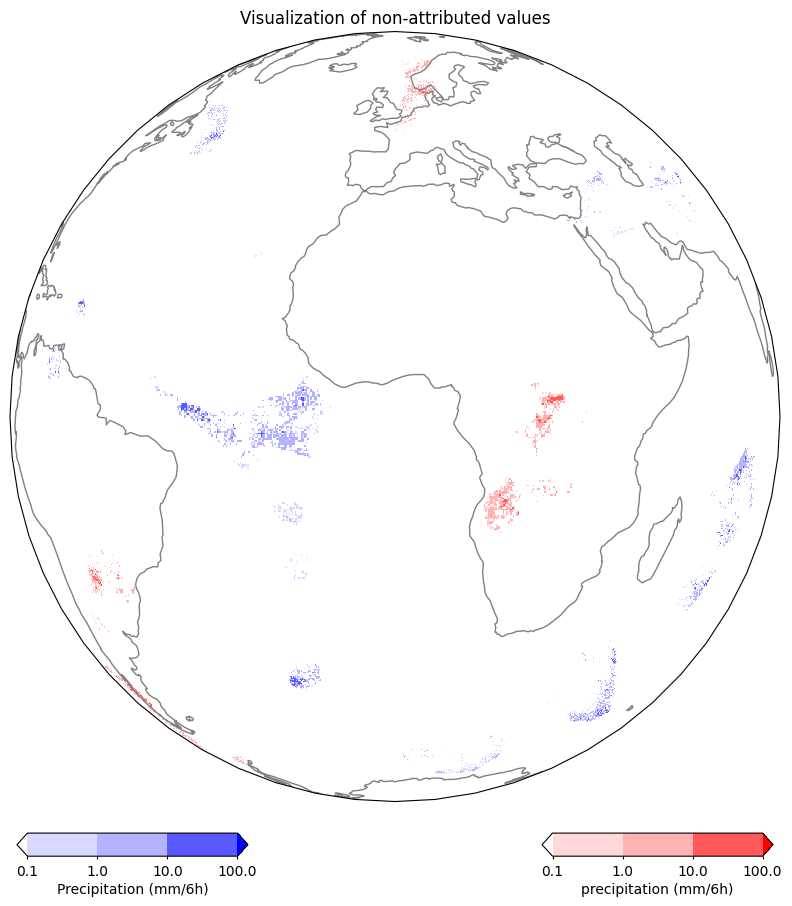

In [11]:
# Visualize non-attributed precipitation in an Orthographic projection

# Divide the non_attributed_values with area size and multiply by 1000 to convert from precipitation volume to precipitation height in mm
non_attributed_values_height1 = non_attributed_values1 / grid_point_area_size * 1000
non_attributed_values_height2 = non_attributed_values2 / grid_point_area_size * 1000

fn1 = np.reshape(non_attributed_values_height1, field1.shape)
fn2 = np.reshape(non_attributed_values_height2, field2.shape)

# Define the projection
projX = cartopy.crs.Orthographic(central_longitude=0, central_latitude=0, globe=None)
projX._threshold = projX._threshold / 50.0  # set finer threshold

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=projX)
ax.set_global()

plt.title("Visualization of non-attributed values")

fontsize = 10

cmap_b = matplotlib.colors.LinearSegmentedColormap.from_list("rb_cmap", ["white", (0.7, 0.7, 1.0), "blue"], 512)
cmap_r = matplotlib.colors.LinearSegmentedColormap.from_list("rb_cmap", ["white", (1.0, 0.7, 0.7), "red"], 512)

levels = [0.1, 1, 10, 100]
norm_b = matplotlib.colors.BoundaryNorm(boundaries=levels, ncolors=cmap_b.N, extend="both")
norm_r = matplotlib.colors.BoundaryNorm(boundaries=levels, ncolors=cmap_r.N, extend="both")

# conver to rgb values using colormaps
f1x = cmap_b(norm_b(fn1))
f2x = cmap_r(norm_r(fn2))

# get the combined colors using the multiply effect
fx = f1x * f2x

img_extent = (0, 360, -90, 90)
img = plt.imshow(
    fx,
    transform=cartopy.crs.PlateCarree(),
    interpolation="nearest",
    origin="lower",
    extent=img_extent,
)

axins_b = inset_axes(
    ax,
    width="30%",
    height="3%",
    bbox_to_anchor=(0.0, -0.08, 1, 1),
    loc="lower left",
    bbox_transform=ax.transAxes,
)
cb_b = matplotlib.colorbar.ColorbarBase(
    axins_b,
    orientation="horizontal",
    cmap=cmap_b,
    norm=norm_b,
    extend="both",
    label="This is a label",
    ticks=levels,
)
cb_b.set_label("Precipitation (mm/6h)", fontsize=fontsize, labelpad=3)
cb_b.ax.tick_params(labelsize=fontsize, length=2)

axins_r = inset_axes(
    ax,
    width="30%",
    height="3%",
    bbox_to_anchor=(0.0, -0.08, 1, 1),
    loc="lower right",
    bbox_transform=ax.transAxes,
)
cb_r = matplotlib.colorbar.ColorbarBase(
    axins_r,
    orientation="horizontal",
    cmap=cmap_r,
    norm=norm_r,
    extend="both",
    label="This is a label",
    ticks=levels,
)
cb_r.set_label("precipitation (mm/6h)", fontsize=fontsize, labelpad=3)
cb_r.ax.tick_params(labelsize=fontsize, length=2)

ax.coastlines(resolution="110m", color="grey", linestyle="-", alpha=1)
# ax.gridlines(draw_labels=False, alpha=0.5)

plt.show()
plt.close()